# Project : Registration of anatomical and functional pelvis images

Charline Curaut 3810013

### Useful libraires and functions

In [80]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
#import imutils

In [81]:
def load_nii(difficulty, f_name):
    
    path = 'EXAMPLE-b0-T2/' + difficulty + '/' + f_name
    img = nib.load(path)
    #print(f'image affine before canonical \n{img.affine}')
    print(f'voxel orientation : {nib.aff2axcodes(img.affine)}')
    canonical_img = nib.as_closest_canonical(img)
    #print(f'image affine after canonical \n{canonical_img.affine}')
    print(f'voxel orientation : {nib.aff2axcodes(canonical_img.affine)}')
    
    return canonical_img.get_fdata()

### Manipulation of data to get familiarized

Let's first put the images along the same voxel orientation.

In [82]:
minor_b0 = load_nii('minor','1-2-14_off_210111_b0DWI.nii')
#print(f'image affine after canonical \n{img.affine}')
print(minor_b0.shape)

minor_T2 = load_nii('minor','1-2-14_off_210111_coroT2Cube.nii')
print(minor_T2.shape)

minor_T2_mask = load_nii('minor','1-2-14_off_210111_T2Mask.nii')
print(minor_T2_mask.shape)

voxel orientation : ('L', 'A', 'S')
voxel orientation : ('R', 'A', 'S')
(256, 256, 75)
voxel orientation : ('R', 'A', 'S')
voxel orientation : ('R', 'A', 'S')
(400, 179, 400)
voxel orientation : ('R', 'A', 'S')
voxel orientation : ('R', 'A', 'S')
(400, 179, 400)


#### Visualization of a slice for each data (it doesn't necessarily correspond) :

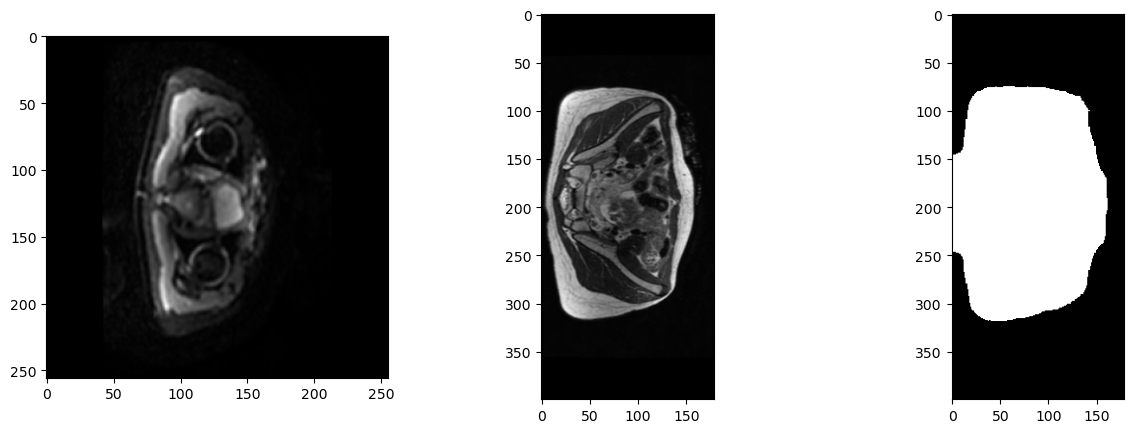

In [98]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
axial_b0 = minor_b0[:,:,30]
plt.imshow(axial_b0, cmap="gray")

plt.subplot(1,3,2)
axial_T2 = minor_T2[:,:,200]
plt.imshow(axial_T2, cmap="gray")

plt.subplot(1,3,3)
axial_T2_mask = minor_T2_mask[:,:,200]
plt.imshow(axial_T2_mask, cmap="gray")

plt.show()

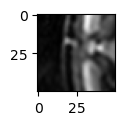

In [99]:
fig = plt.figure(figsize=(1,5))
plt.imshow(test_b0[100:150,50:100], cmap='gray')
plt.show()

The coordinates are in RAS+ so we have (x,y,z) with x that increases to the Right, y that increases to the Anterior part, and z that increases to Superior part. Here, the images are displayed with the x axis being the vertical axis, and the y axis being the horizontal axis. 

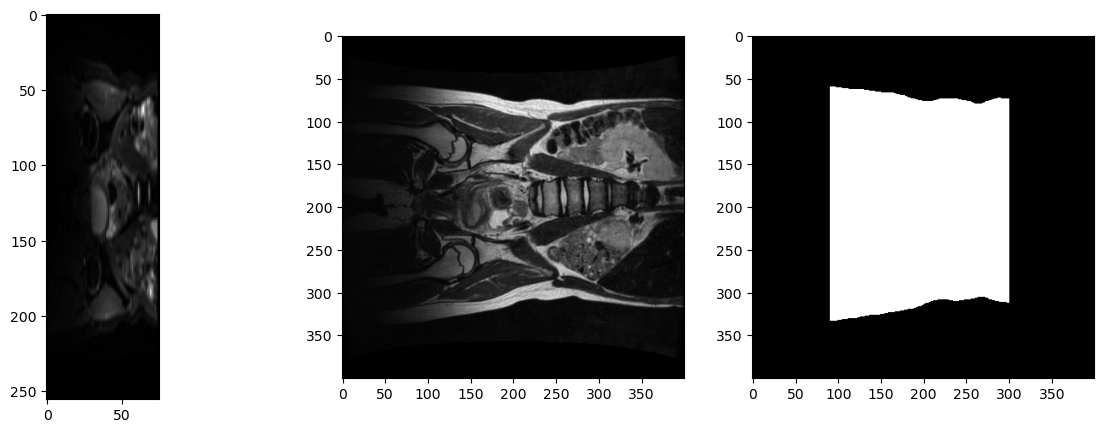

In [101]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
coronal_b0 = minor_b0[:,127,:]
plt.imshow(coronal_b0, cmap="gray")

plt.subplot(1,3,2)
coronal_T2 = minor_T2[:,80,:]
plt.imshow(coronal_T2, cmap="gray")

plt.subplot(1,3,3)
coronal_T2_mask = minor_T2_mask[:,80,:]
plt.imshow(coronal_T2_mask, cmap="gray")

plt.show()

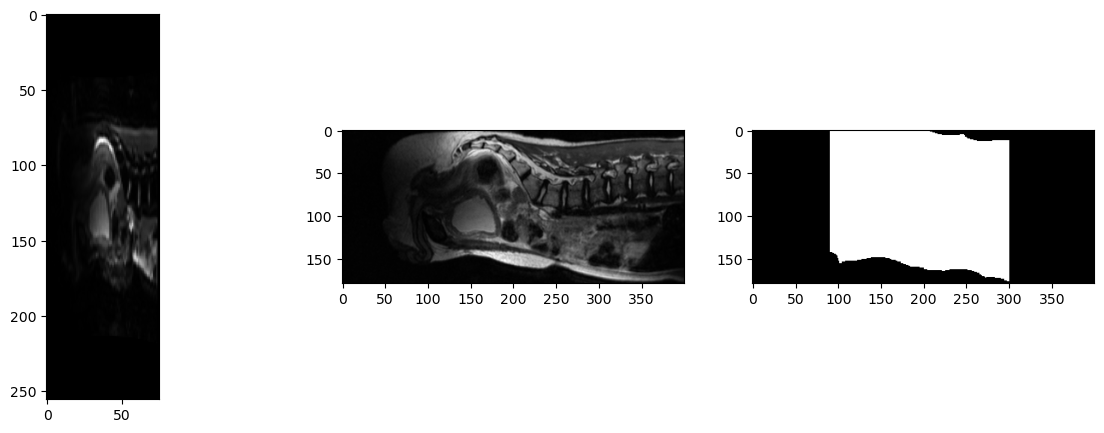

In [102]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sagittal_b0 = minor_b0[127,:,:]
plt.imshow(sagittal_b0, cmap="gray")

plt.subplot(1,3,2)
sagittal_T2 = minor_T2[200,:,:]
plt.imshow(sagittal_T2, cmap="gray")

plt.subplot(1,3,3)
sagittal_T2_mask = minor_T2_mask[200,:,:]
plt.imshow(sagittal_T2_mask, cmap="gray")

plt.show()

#### Cuting axial slice T2 according to given mask

In [119]:
# on manipule chaque coupe coronale pour éliminer des coupes axiales.

def cut_T2_coro(T2, T2_mask) :
    """ 
    Search for each coronal slice the first and last y-coordinate pixel (which correspond to z-corrdinate voxel)
    Return a cut version of T2 (with less axial slices)
    """

    z_max = 0
    z_min = T2.shape[2]

    for i in range(T2.shape[1]) :
        slice_coro = T2[:,i,:]
        slice_coro_mask = T2_mask[:,i,:]

        for y in range(slice_coro.shape[1]) :
            if 1.0 in slice_coro_mask[:,y]:
                if y < z_min :
                    z_min = y
                break

        for y in range(slice_coro.shape[1]-1,-1,-1) :
            if 1.0 in slice_coro_mask[:,y] :
                if y > z_max :
                    z_max = y
                break
                

    return T2[:,:,z_min:z_max], T2_mask[:,:,z_min:z_max]

In [120]:
minor_T2_cut, minor_T2_mask_cut = cut_T2_coro(minor_T2, minor_T2_mask)
print(minor_T2_cut.shape)

(400, 179, 209)


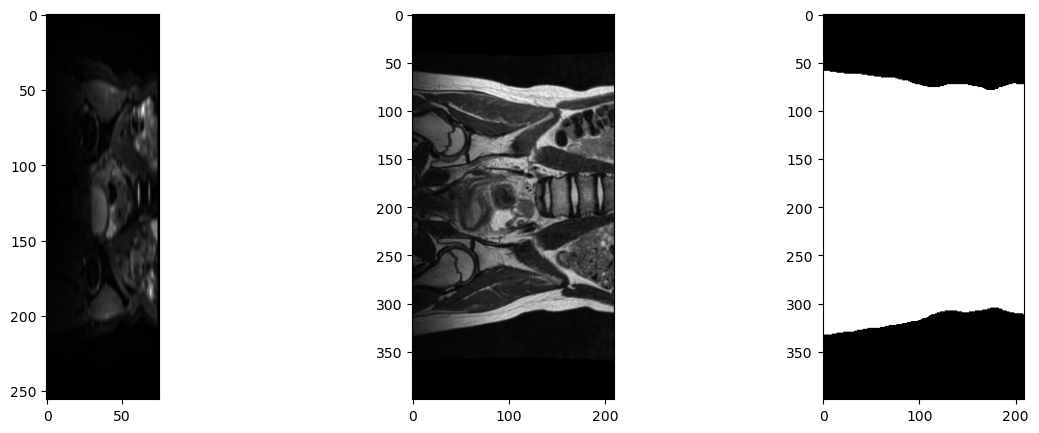

In [122]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
coronal_b0 = minor_b0[:,127,:]
plt.imshow(coronal_b0, cmap="gray")

plt.subplot(1,3,2)
coronal_T2_cut = minor_T2_cut[:,80,:]
plt.imshow(coronal_T2_cut, cmap="gray")

plt.subplot(1,3,3)
coronal_T2_mask_cut = minor_T2_mask_cut[:,80,:]
plt.imshow(coronal_T2_mask_cut, cmap="gray")

plt.show()

Right now there are 75 axial b0 slices of thickness 3.5 mm, and 209 axial T2 slices of thickness 0.8 mm. We still have to resample T2. Which mean that the size of the coronal region covered by b0 is $75 * 3.5 = 262.5 mm$ and the one covered by T2 is $ 209 * 0.8 = 167.2 mm$. The surface of T2 is now lesser than that of b0. 

Ce n'est peut être pas la bonne méthode (ajuster la taille des images jusqu'à avoir une surface environ équivalente) pour faire le ré-échantillonage.
--> à la place : utiliser la matrice affine qui fait passer les coordonnées des voxels dans l'espace Scanner RAS+ --> ça met les deux images en relation et on peut comparer les slices axiales entre elles.